## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.metrics import f1_score

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Loading Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Conclusion: We need to handle two missing values in the columns `average_rating` and `votes`. Since there are only two missing records, we will discard these entries.


In [6]:
df_reviews.dropna(subset=['average_rating', 'votes'], inplace=True)

In [7]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
34816,tt0051418,movie,The Blob,The Blob,1958,\N,86,0,"Horror,Sci-Fi",6.4,22058,The Blob is a classic 1950s B-movie sci-fi fli...,8,pos,1,train,8923
10348,tt0819765,movie,Dog Bite Dog,Gau ngao gau,2006,\N,109,0,"Action,Crime,Drama",6.6,2335,Finally we have before us a Category III movie...,8,pos,1,train,9577
28840,tt0114287,movie,Rob Roy,Rob Roy,1995,\N,139,0,"Adventure,Biography,Drama",6.9,39765,I had never heard of Robert Roy MacGregor befo...,7,pos,1,train,4364
36111,tt0092843,movie,The Dead,The Dead,1987,\N,83,0,Drama,7.3,6907,Naturally in a film who's main themes are of m...,10,pos,1,test,12311
2709,tt0047834,movie,Animal Farm,Animal Farm,1954,\N,72,0,"Animation,Drama",7.2,14739,Animal Farm (1954) was a very good read about ...,3,neg,0,train,7880
32690,tt0425483,movie,Strange Fruit,Strange Fruit,2004,\N,115,0,"Drama,Mystery,Thriller",5.5,224,This is a movie with an excellent concept for ...,3,neg,0,test,3792
25802,tt0025628,short,"Paree, Paree","Paree, Paree",1934,\N,21,0,"Comedy,Musical,Romance",6.2,205,"A delight mini movie, a musical short based on...",7,pos,1,train,5264
14864,tt0455957,movie,Goya's Ghosts,Goya's Ghosts,2006,\N,113,0,"Biography,Drama,History",6.9,28903,This isn't exactly a complicated story. It's n...,3,neg,0,test,8878
3073,tt0291022,movie,Aro Tolbukhin in the Mind of a Killer,Aro Tolbukhin - En la mente del asesino,2002,\N,95,0,Drama,6.6,436,There's so many things to fall for in Aro Tolb...,9,pos,1,train,10024
7570,tt0075862,tvMovie,Code Name: Diamond Head,Code Name: Diamond Head,1977,\N,78,0,"Action,Crime,Drama",2.6,460,This series would have been a lot better if th...,2,neg,0,train,5189


In [12]:
df_reviews.duplicated().value_counts()

False    47329
dtype: int64

## Exploratory Data Analysis

Checking number of movies and reviews through the years

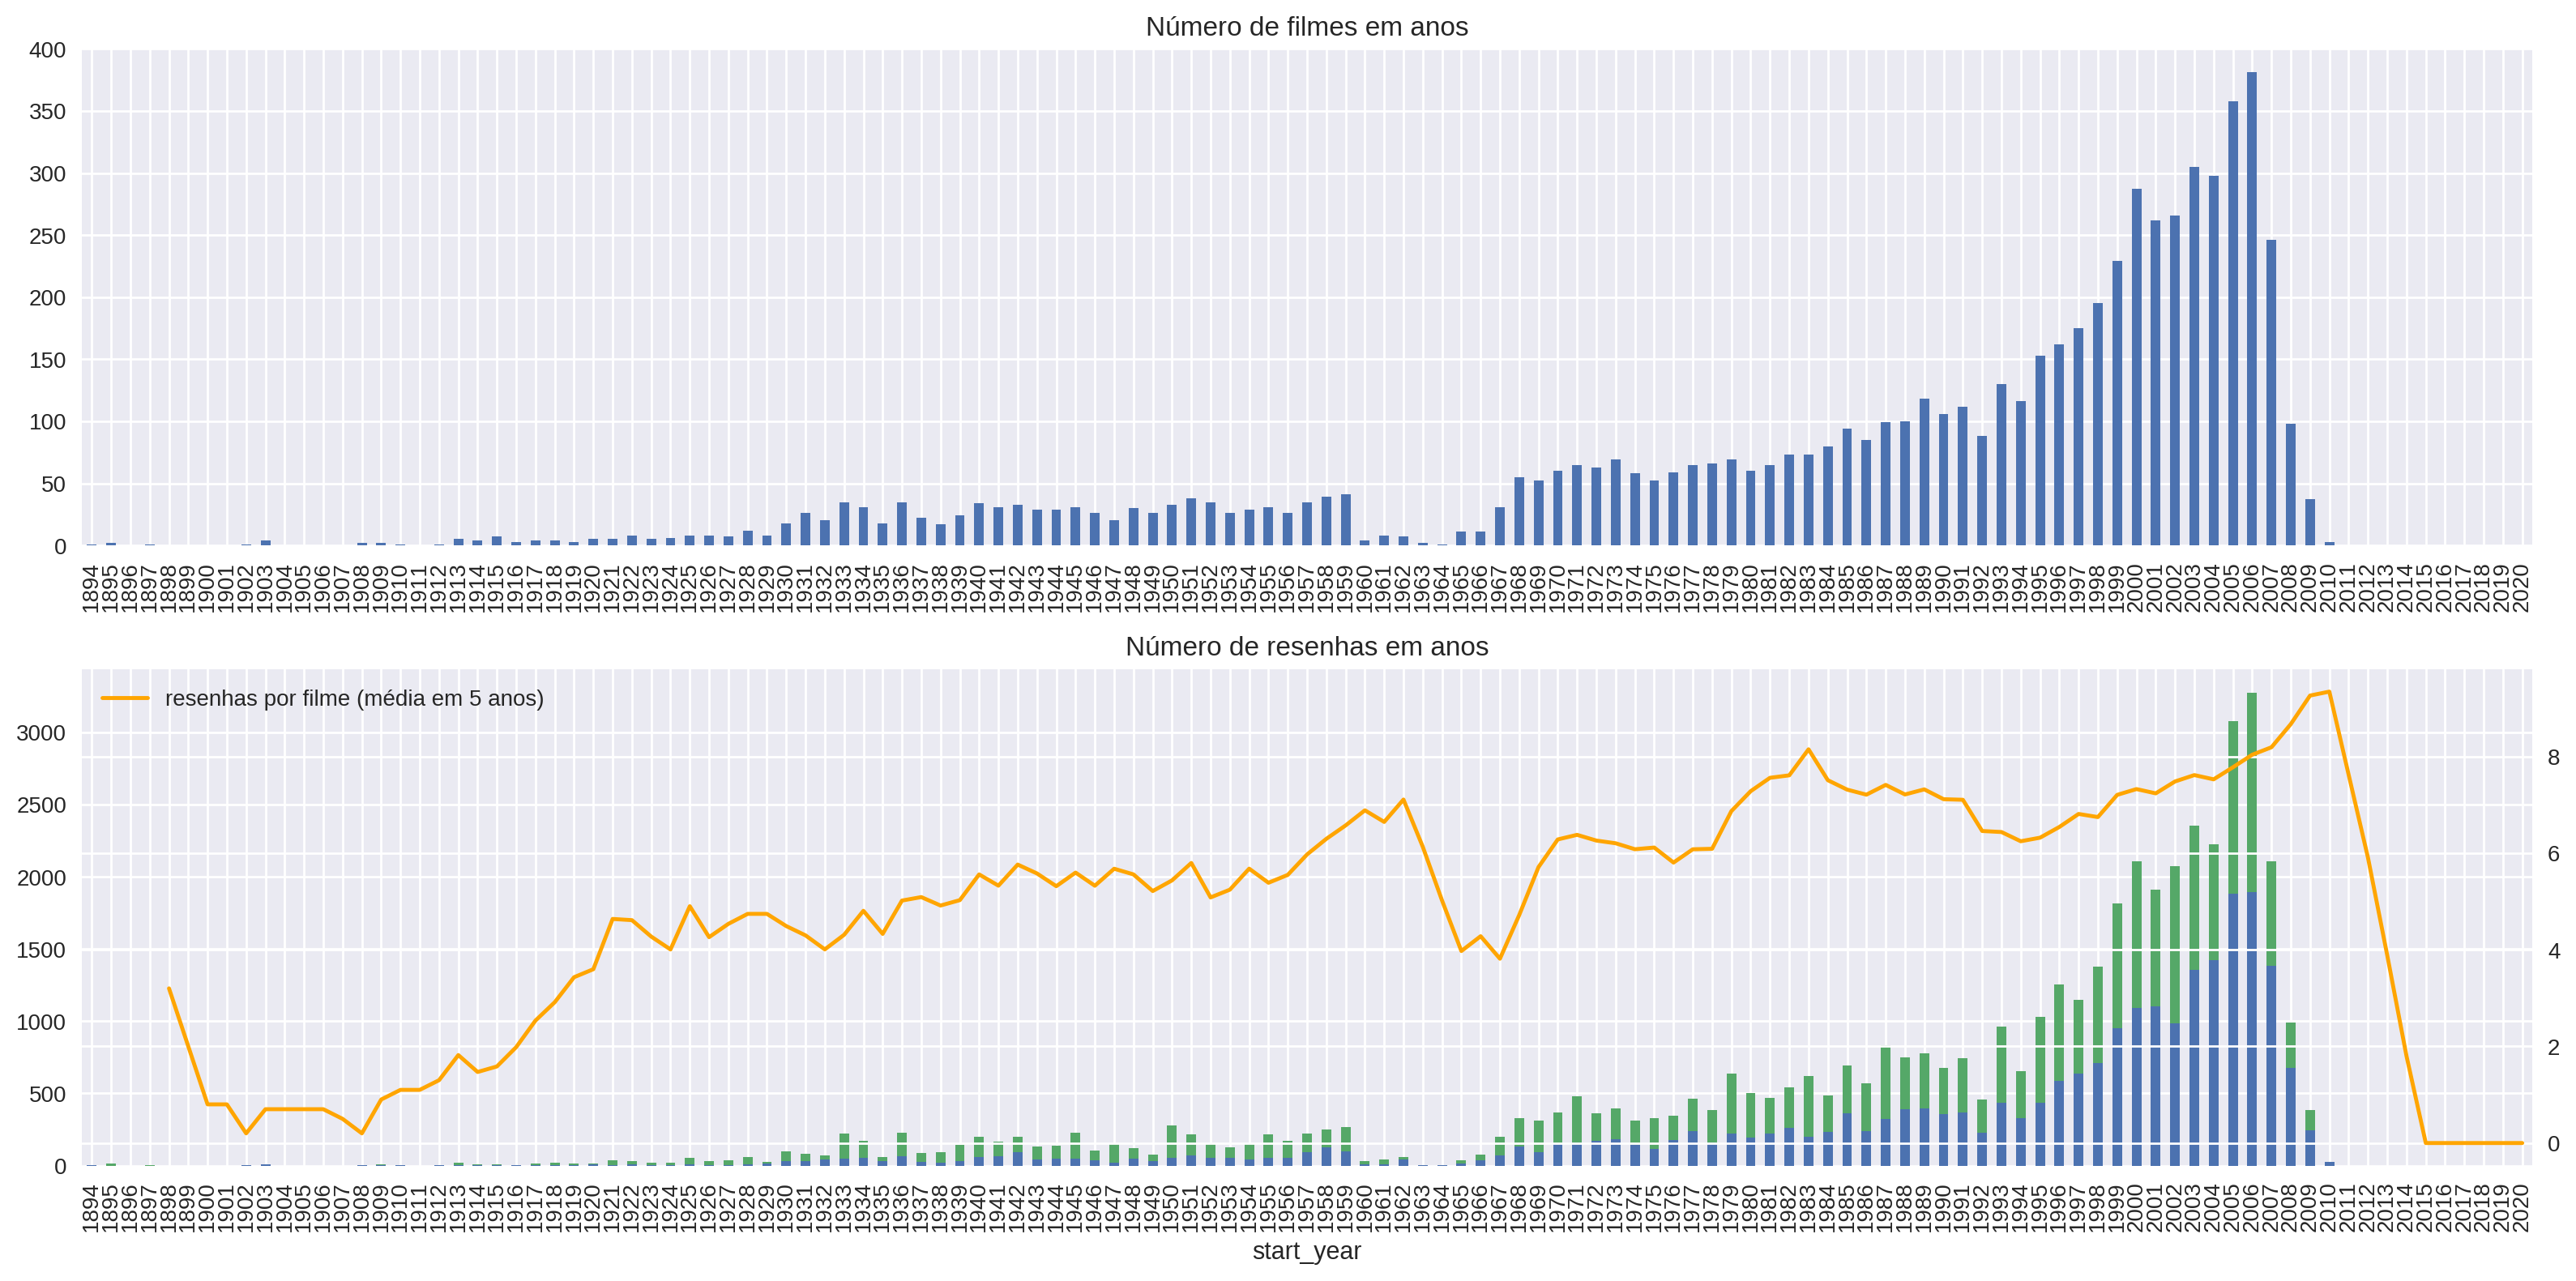

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Conclusion: We observed few reviews for movies released before 1967, with fewer than 50 films per year up to that point. After this year, the number of reviews and film releases increased, peaking in 2006 with almost 400 films and over 3,000 reviews. After 2010, there are no records of films or reviews. The moving average of reviews shows a growth trend throughout the entire period, except after 2010 when it begins to decline.


Let's check the distribution of the number of reviews per film with the exact count and the KDE (Kernel Density Estimation - just to see how it may differ from the exact count).


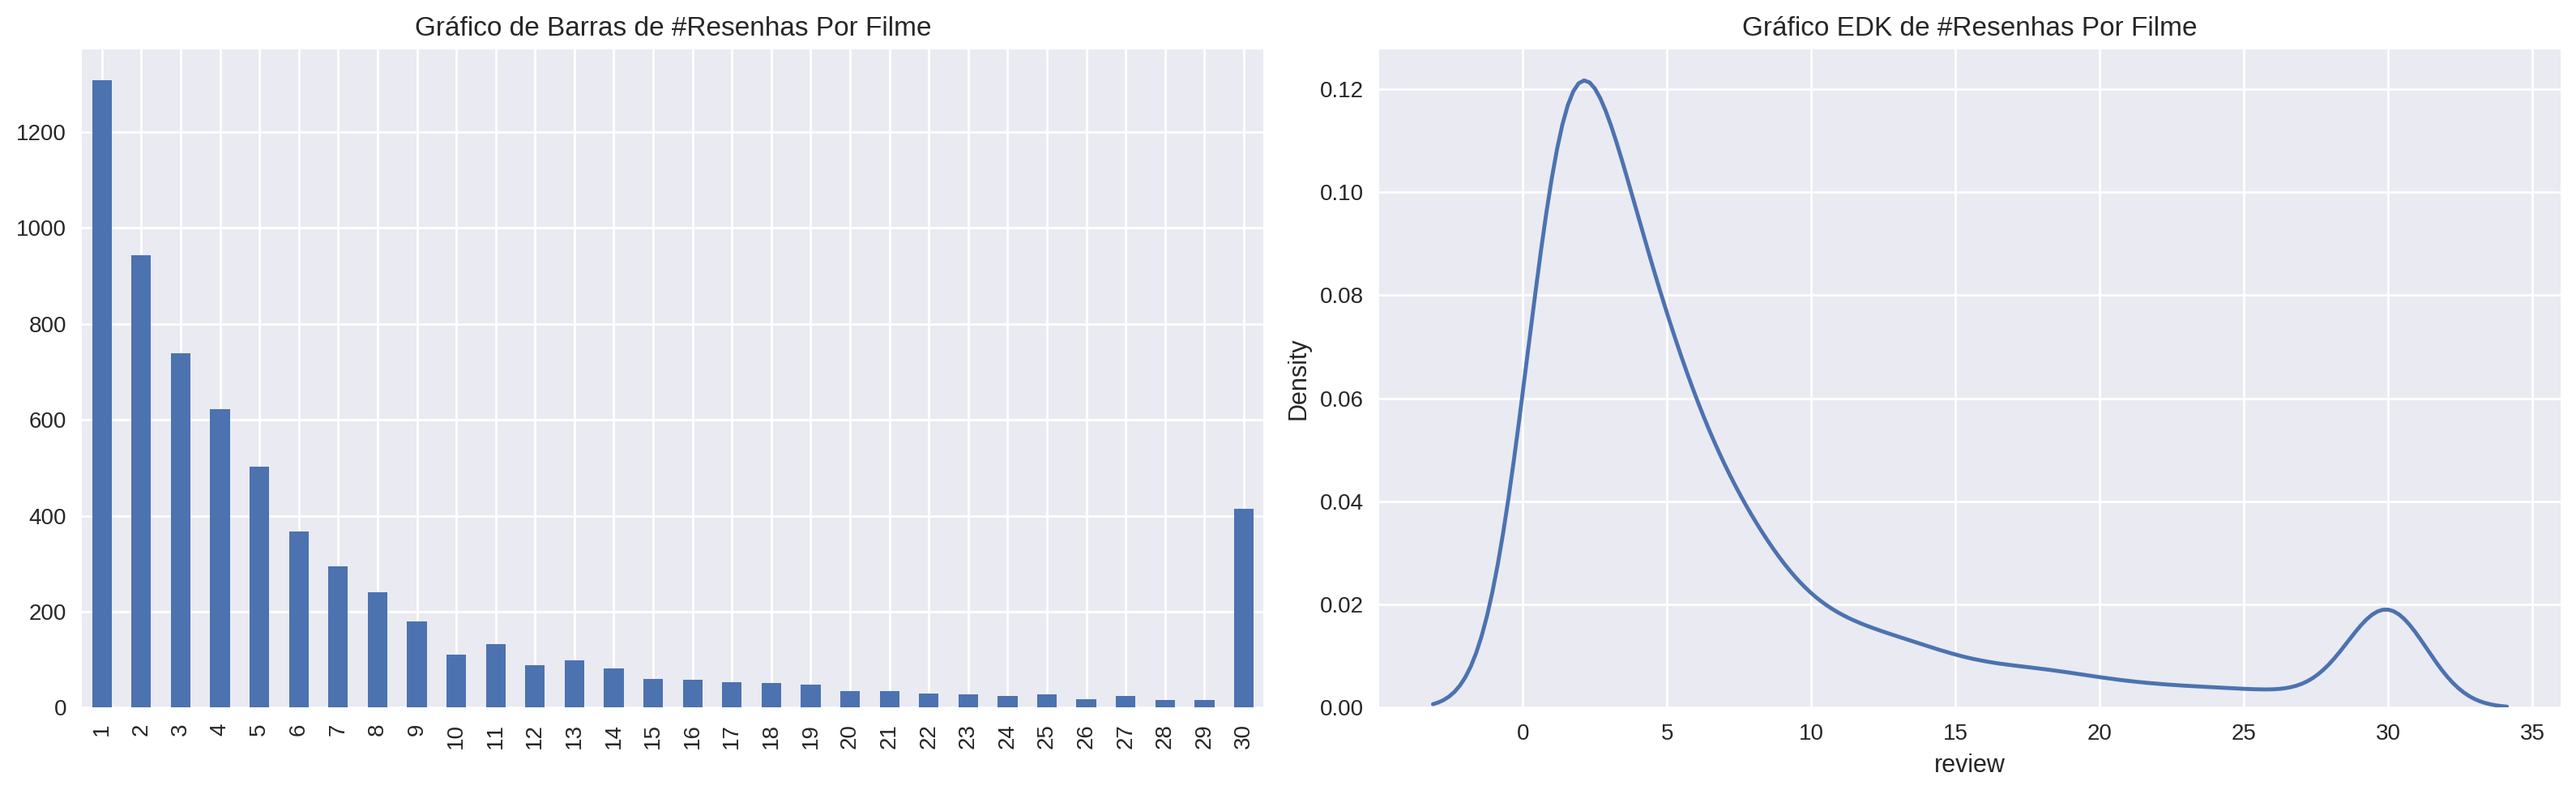

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

Conclusions:
- We can see many movies with a single review. 
- As reviews increase in number, the quantity of movies drops. 
- We can see some movies with 30 reviews

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

In [13]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501067
1    0.498933
Name: pos, dtype: float64

Conclusion: No class unbalance was detected, because pos 0 and pos 1 have roughly the same quantity of observations

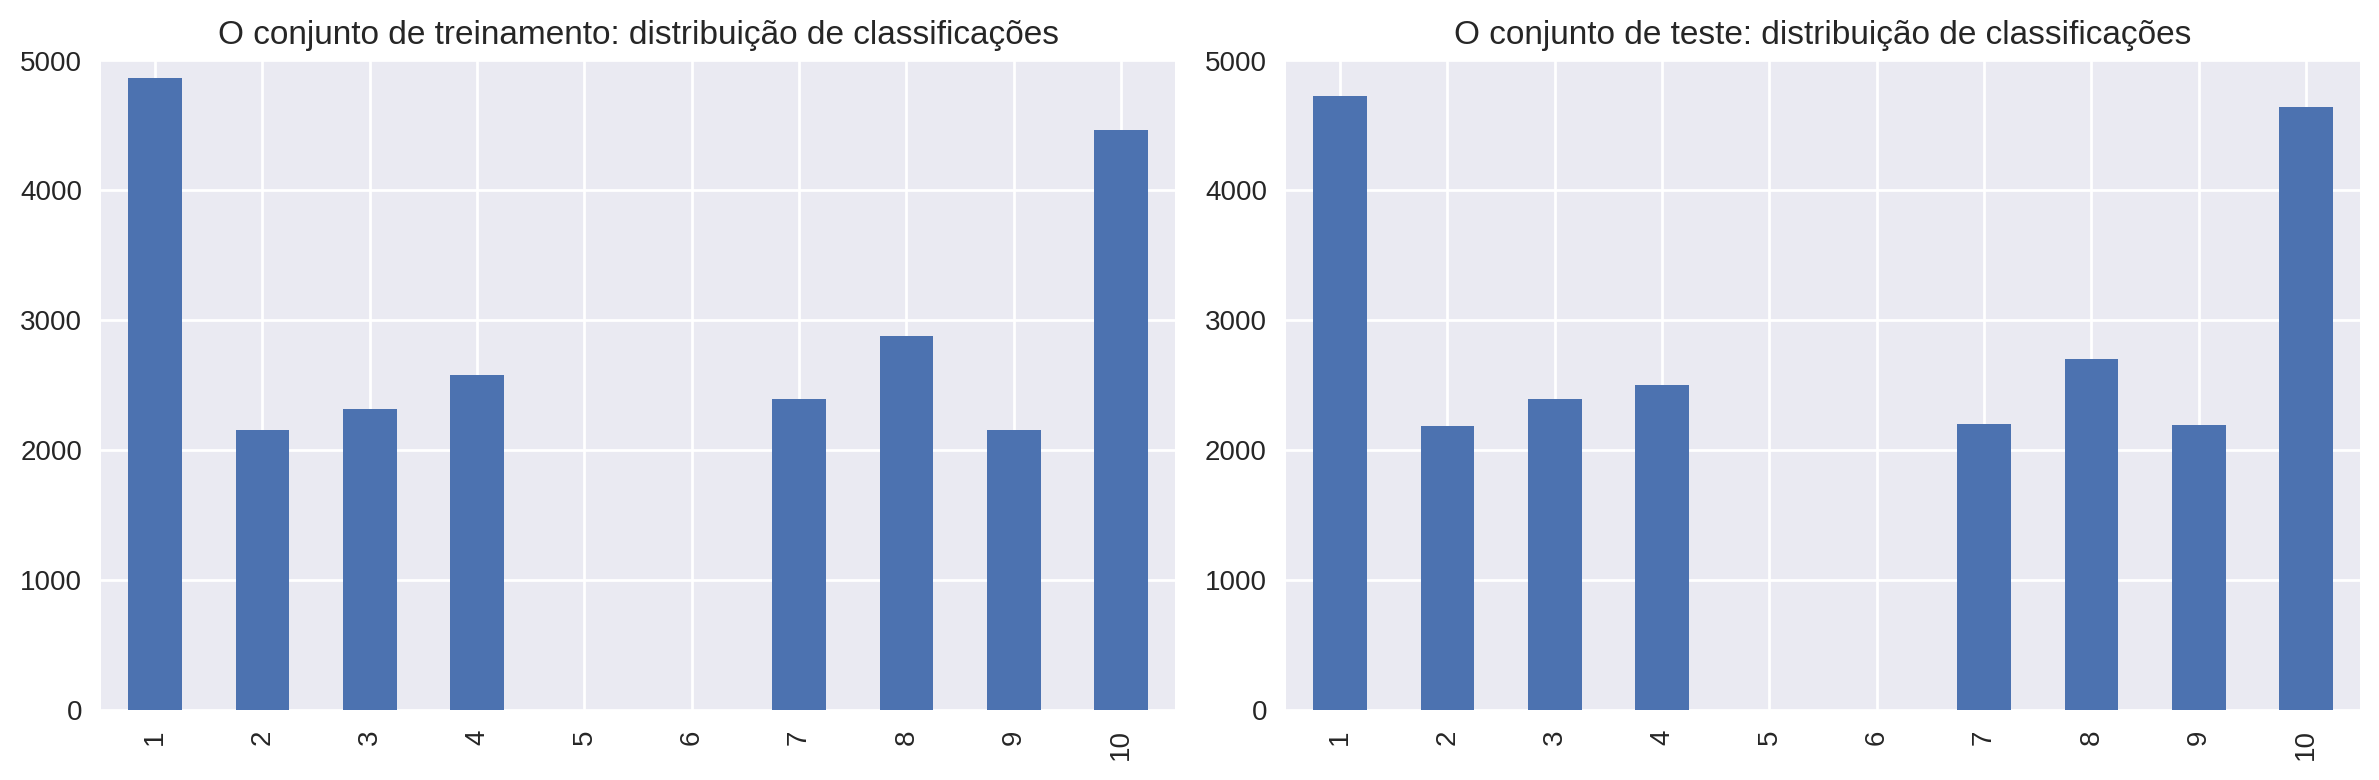

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Conclusion: The training and test sets have similar distributions of ratings, indicating that the data split between training and test has produced comparable datasets.


Distribution of negative and positive reviews over the years for both parts of the dataset.


/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


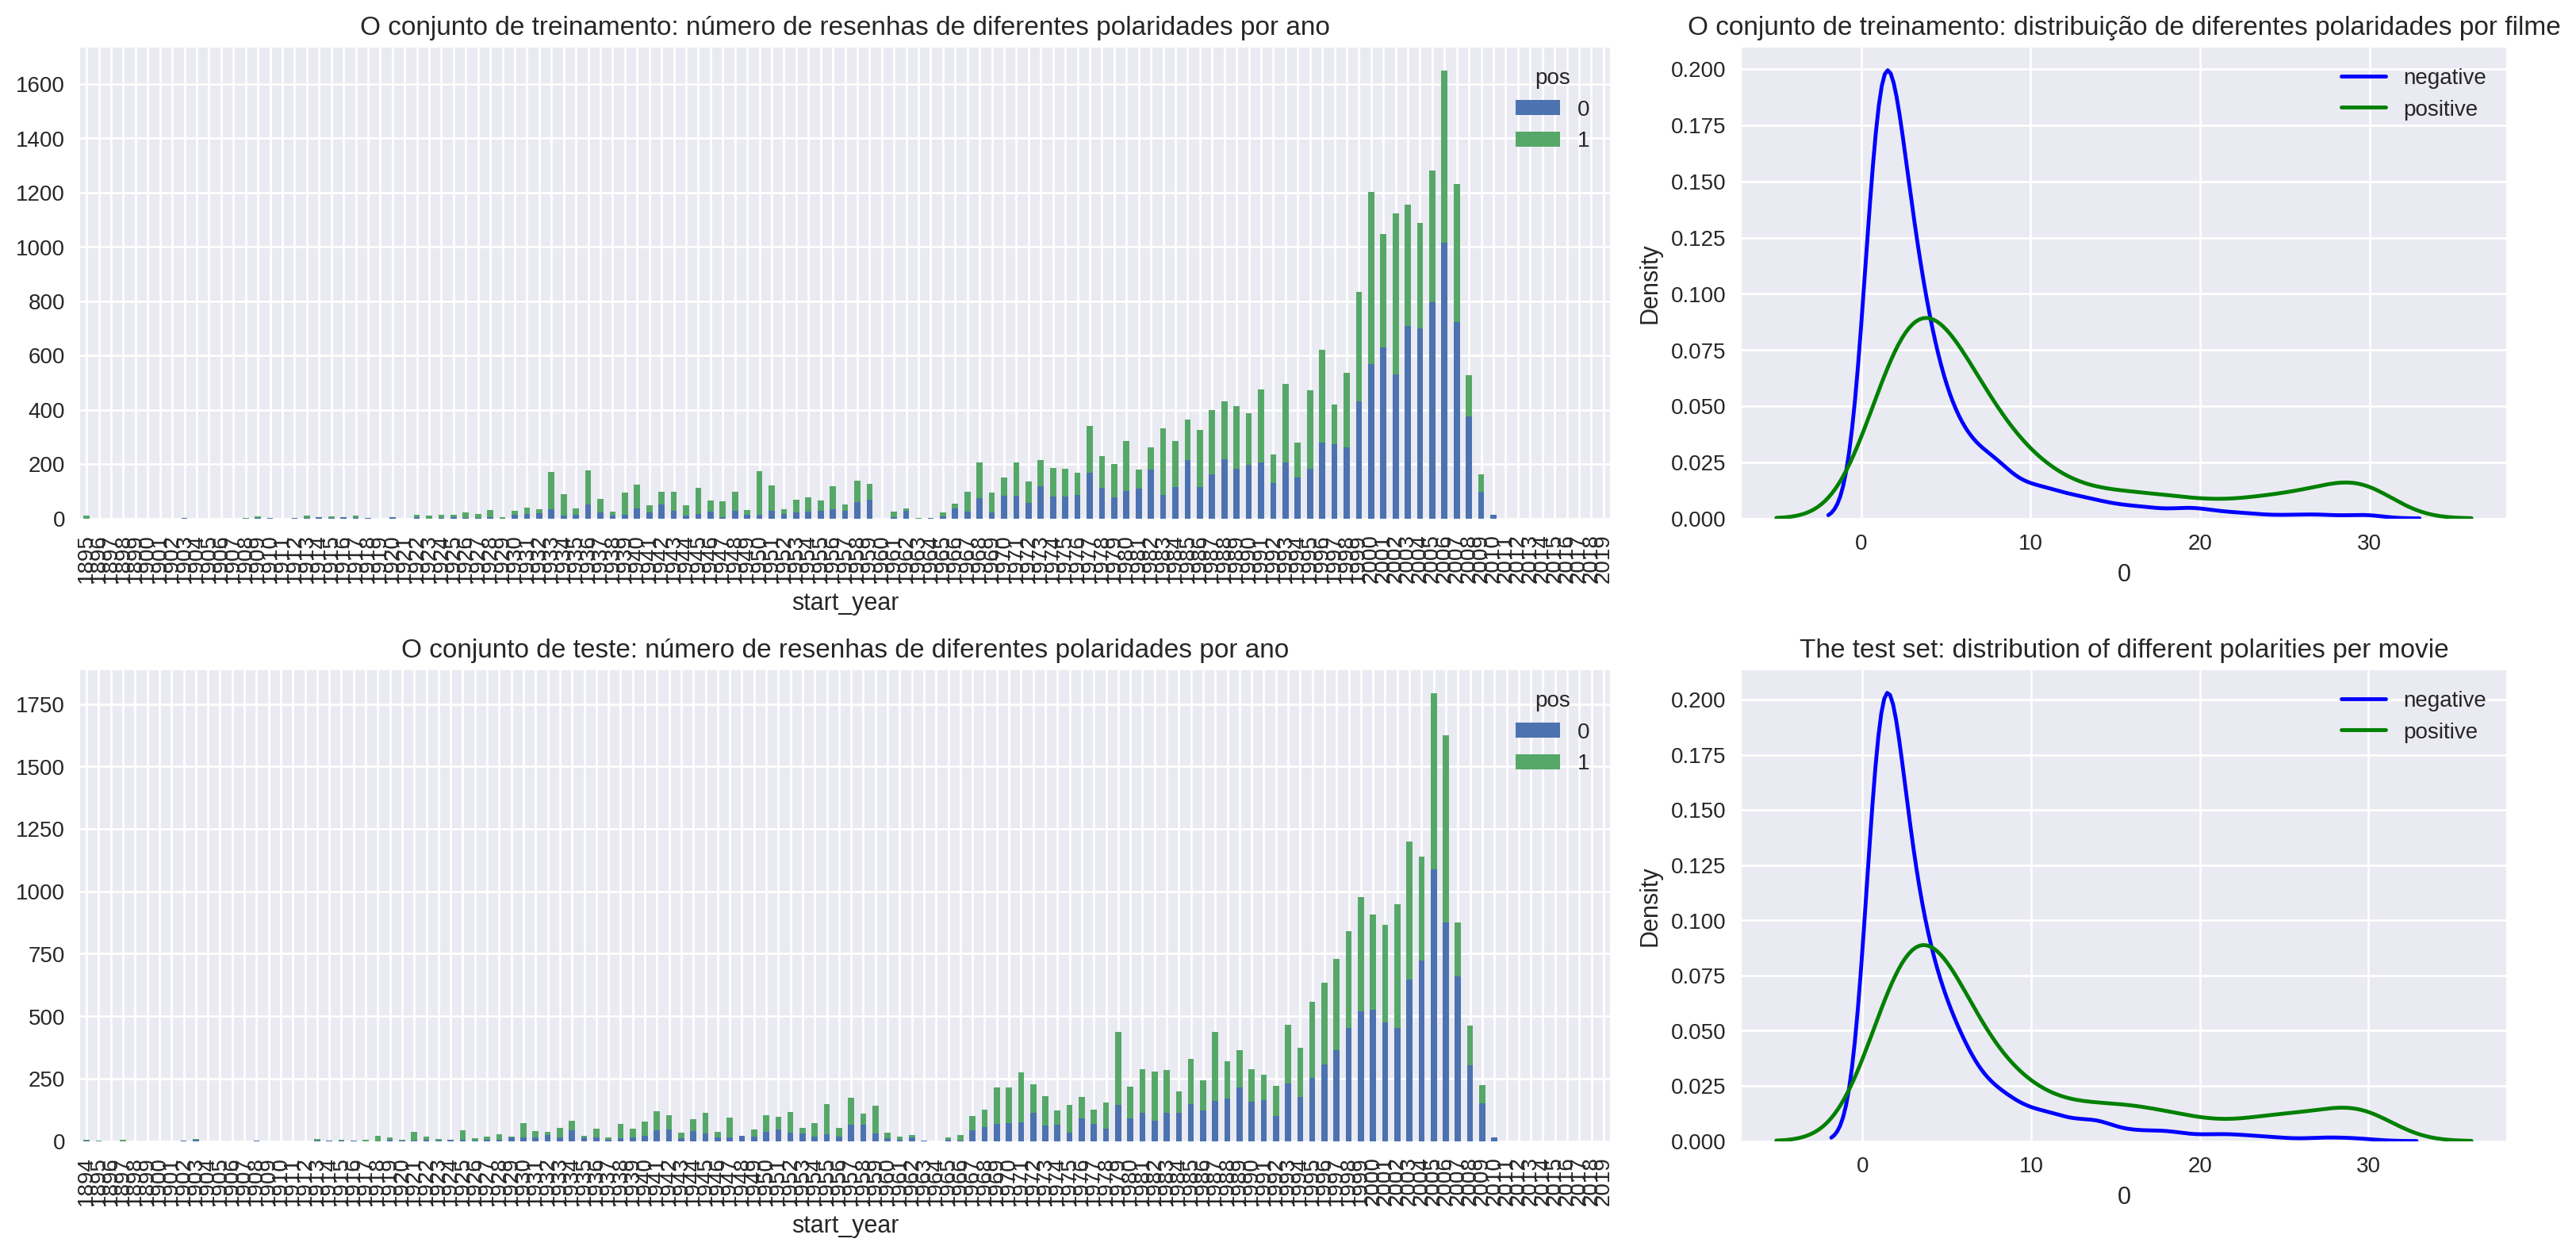

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Conclusion: We observed a gradual increase in the number of reviews over the years, as well as the number of films, especially after 1967, reaching a peak in 2006 with nearly 400 films and over 3,000 reviews in that year.

We also noted that when films have only one or a few reviews, they tend to be more negative than positive.


## Evaluation Procedure

Composing an evaluation routine that can be used across all models in this project.


In [37]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume that all models below accept text in lowercase, without digits, punctuation marks, etc.


In [28]:
df_reviews['review_norm'] = df_reviews["review"].str.lower().str.replace("[^a-zA-Z]"," ")

## Training and Testing Datasets

Fortunately, the entire dataset is already divided into training and test sets. The corresponding column for this split is `'ds_part'`.


In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [16]:
df_reviews_train.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
34416,tt0051398,movie,The Barbarian and the Geisha,The Barbarian and the Geisha,1958,\N,105,0,"Adventure,Drama,History",5.7,1730,I found this to be a surprisingly light-handed...,8,pos,1,train,9288,i found this to be a surprisingly light handed...
5691,tt0460628,tvMiniSeries,Britney & Kevin: Chaotic,Britney & Kevin: Chaotic,2005,\N,150,0,"Music,Reality-TV,Romance",2.6,707,I don't know why I'm commenting this stupid re...,1,neg,0,train,5001,i don t know why i m commenting this stupid re...
13609,tt0264616,movie,Frailty,Frailty,2001,\N,100,0,"Crime,Drama,Thriller",7.2,74539,What a real treat and quite unexpected. This i...,10,pos,1,train,5038,what a real treat and quite unexpected this i...
28214,tt0217000,videoGame,Resident Evil: Code: Veronica,Resident Evil: Code: Veronica,2000,\N,\N,0,"Action,Horror,Mystery",8.2,2588,Resident Evil:code veronica is a great well ma...,10,pos,1,train,7575,resident evil code veronica is a great well ma...
14315,tt0322389,video,George of the Jungle 2,George of the Jungle 2,2003,\N,87,0,"Adventure,Comedy,Family",3.3,6205,Allow me to just get to the bottom line here: ...,8,pos,1,train,8527,allow me to just get to the bottom line here ...
28804,tt0257044,movie,Road to Perdition,Road to Perdition,2002,\N,117,0,"Crime,Drama,Thriller",7.7,240986,The highlight of this movie for me was without...,4,neg,0,train,2910,the highlight of this movie for me was without...
46734,tt0049966,movie,Written on the Wind,Written on the Wind,1956,\N,99,0,Drama,7.5,9756,I watched Written on The Wind starring Rock Hu...,4,neg,0,train,2345,i watched written on the wind starring rock hu...
29388,tt0115341,tvSeries,Sabrina the Teenage Witch,Sabrina the Teenage Witch,1996,2003,22,0,"Comedy,Family,Fantasy",6.6,32924,"And it's not because since her days on ""Claris...",10,pos,1,train,6705,and it s not because since her days on claris...
17130,tt0093223,movie,House of Games,House of Games,1987,\N,102,0,"Crime,Thriller",7.3,20100,David Mamet wrote the screenplay and made his ...,10,pos,1,train,10285,david mamet wrote the screenplay and made his ...
10058,tt0069976,movie,Dillinger,Dillinger,1973,\N,107,0,"Action,Biography,Crime",7.0,4510,"Near the beginning, after it's been establishe...",4,neg,0,train,11028,near the beginning after it s been establishe...


In [30]:
df_reviews_train.drop(columns=["sp","pos"],inplace=True)
df_reviews_test.drop(columns=["sp","pos"],inplace=True)

In [18]:
df_reviews_train.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,ds_part,idx,review_norm
35077,tt0075781,movie,The Brain Machine,The Brain Machine,1977,\N,85,0,"Sci-Fi,Thriller",3.0,391,Someone mentioned editing. This is edited badl...,3,train,1401,someone mentioned editing this is edited badl...
42969,tt0068966,movie,The Witches Mountain,El monte de las brujas,1973,\N,80,0,Horror,3.9,360,This movie got off to an interesting start. Do...,4,train,8537,this movie got off to an interesting start do...
36560,tt0116581,movie,The Eighth Day,Le huitième jour,1996,\N,118,0,"Comedy,Drama",7.5,8775,"When I first saw this movie, I thought it was ...",10,train,2755,when i first saw this movie i thought it was ...
35403,tt0398842,movie,The Celestine Prophecy,The Celestine Prophecy,2006,\N,99,0,"Adventure,Drama",4.9,3534,"At first, three words: READ THE BOOK! Really g...",2,train,4540,at first three words read the book really g...
36191,tt0490878,movie,The Decoy,The Decoy,2006,\N,109,0,Western,3.6,163,Great western I hear you all say! Brilliant fi...,1,train,7251,great western i hear you all say brilliant fi...
33601,tt0025862,movie,Tarzan and His Mate,Tarzan and His Mate,1934,\N,104,0,"Action,Adventure",7.3,4669,As noted by other reviewers this is one of the...,8,train,11287,as noted by other reviewers this is one of the...
7819,tt0037610,movie,Confidential Agent,Confidential Agent,1945,\N,118,0,"Drama,Thriller",6.5,927,An underrated addition to the Graham Greene ci...,7,train,3034,an underrated addition to the graham greene ci...
5280,tt0197311,movie,Boesman and Lena,Boesman and Lena,2000,\N,90,0,Drama,6.1,237,] Haven't seen this film? Haven't even heard o...,9,train,8431,haven t seen this film haven t even heard o...
33858,tt0013662,movie,Tess of the Storm Country,Tess of the Storm Country,1922,\N,137,0,"Drama,Romance",6.9,415,TESS OF THE STORM COUNTRY is possibly the best...,10,train,7858,tess of the storm country is possibly the best...
17948,tt0061809,movie,In Cold Blood,In Cold Blood,1967,\N,134,0,"Biography,Crime,Drama",7.9,23264,"Sorry, I don't have much time to write. I am n...",10,train,2731,sorry i don t have much time to write i am n...


## Working with Models

### Model 0 - Constant

In [19]:
from sklearn.dummy import DummyClassifier

In [31]:
dummy_clf = DummyClassifier(strategy='constant',constant=1)
model0 = dummy_clf.fit(X=df_reviews_train,y=train_target)

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


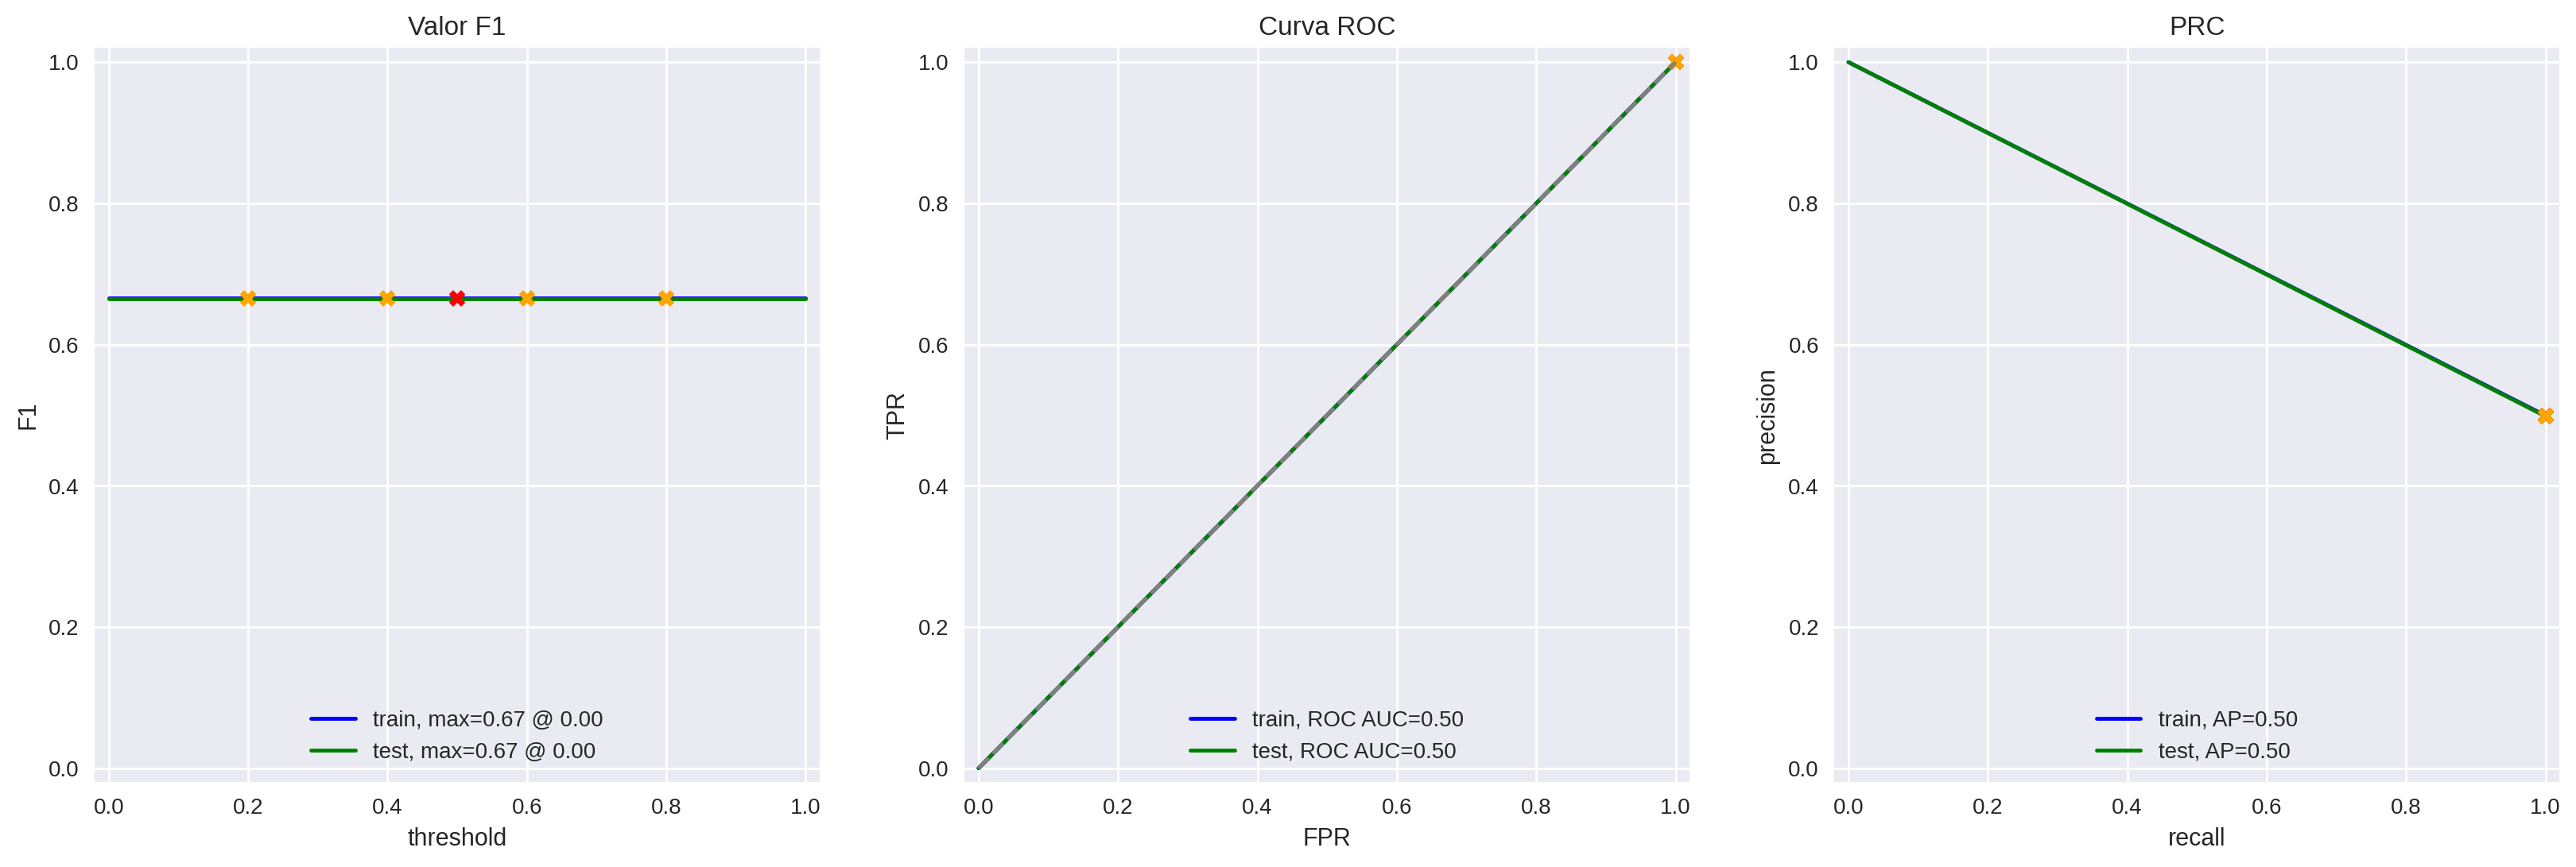

In [38]:
evaluate_model(model0, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

### Model 1 - NLTK, TF-IDF and Logistic Regression

TF-IDF

In [22]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [33]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'),lowercase=True)

train_features = tfidf_vectorizer_1.fit_transform(df_reviews_train["review_norm"])
print(train_features.shape)

(23796, 71531)


In [34]:
test_features = tfidf_vectorizer_1.transform(df_reviews_test["review_norm"])
print(test_features.shape)

(23533, 71531)


In [35]:
model1 = LogisticRegression()
model1.fit(train_features,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


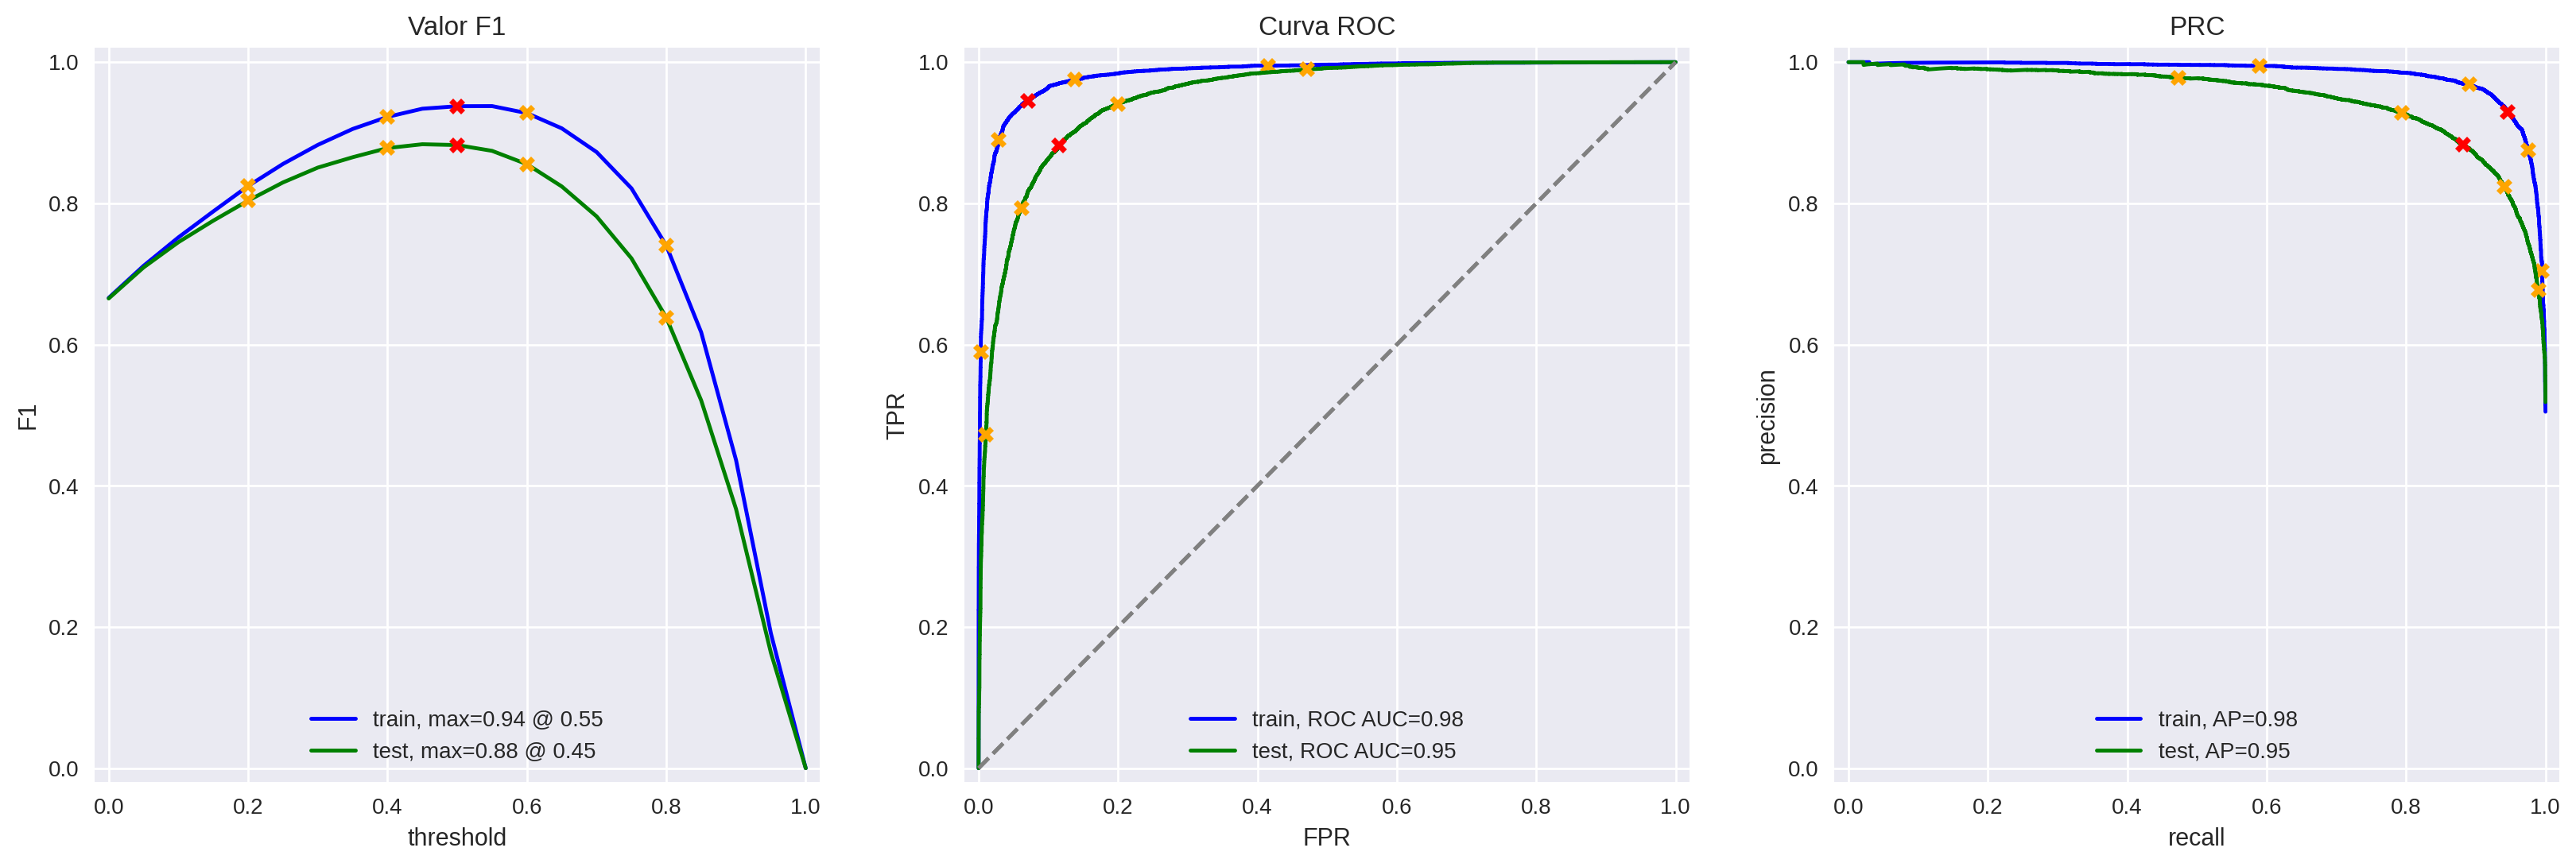

In [39]:
evaluate_model(model1, train_features, train_target, test_features, test_target)

### Model 3 - spaCy, TF-IDF and Logistic Regression

In [40]:
import spacy
import random
import re

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [41]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [42]:
df_reviews_train["review_tokenized_3"] = df_reviews_train["review_norm"].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

In [43]:
df_reviews_test["review_tokenized_3"] = df_reviews_test["review_norm"].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23533 [00:00<?, ?it/s]

In [44]:
df_reviews_train["review_tokenized_3"].sample(5)

3535     big piece crap   look like spend time   effort...
8297     movie insult submariner   stupid   appear writ...
8908     m sure click   contain spoiler    honestly exp...
11711    think movie absolutely beautiful   m refer bre...
32437        year old immensely happy able good look fa...
Name: review_tokenized_3, dtype: object

In [45]:
df_reviews_test["review_tokenized_3"].sample(5)

14696    firstly   adaptation stephen king book   short...
15920    like   blair witch project      hatchet   garn...
1231     s dull moment francois ozon s   robe d ete    ...
21716    marry mob vhs tape come america grease   fond ...
2692     have close experience patient probably good re...
Name: review_tokenized_3, dtype: object

In [46]:
tfidf_vectorizer_3 = TfidfVectorizer()

In [47]:
train_features3 = tfidf_vectorizer_3.fit_transform(df_reviews_train["review_tokenized_3"])
print(train_features3.shape)

(23796, 59340)


In [49]:
test_features3 = tfidf_vectorizer_3.transform(df_reviews_test["review_tokenized_3"])
print(test_features3.shape)

(23533, 59340)


In [50]:
model3 = LogisticRegression()
model3.fit(train_features3,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


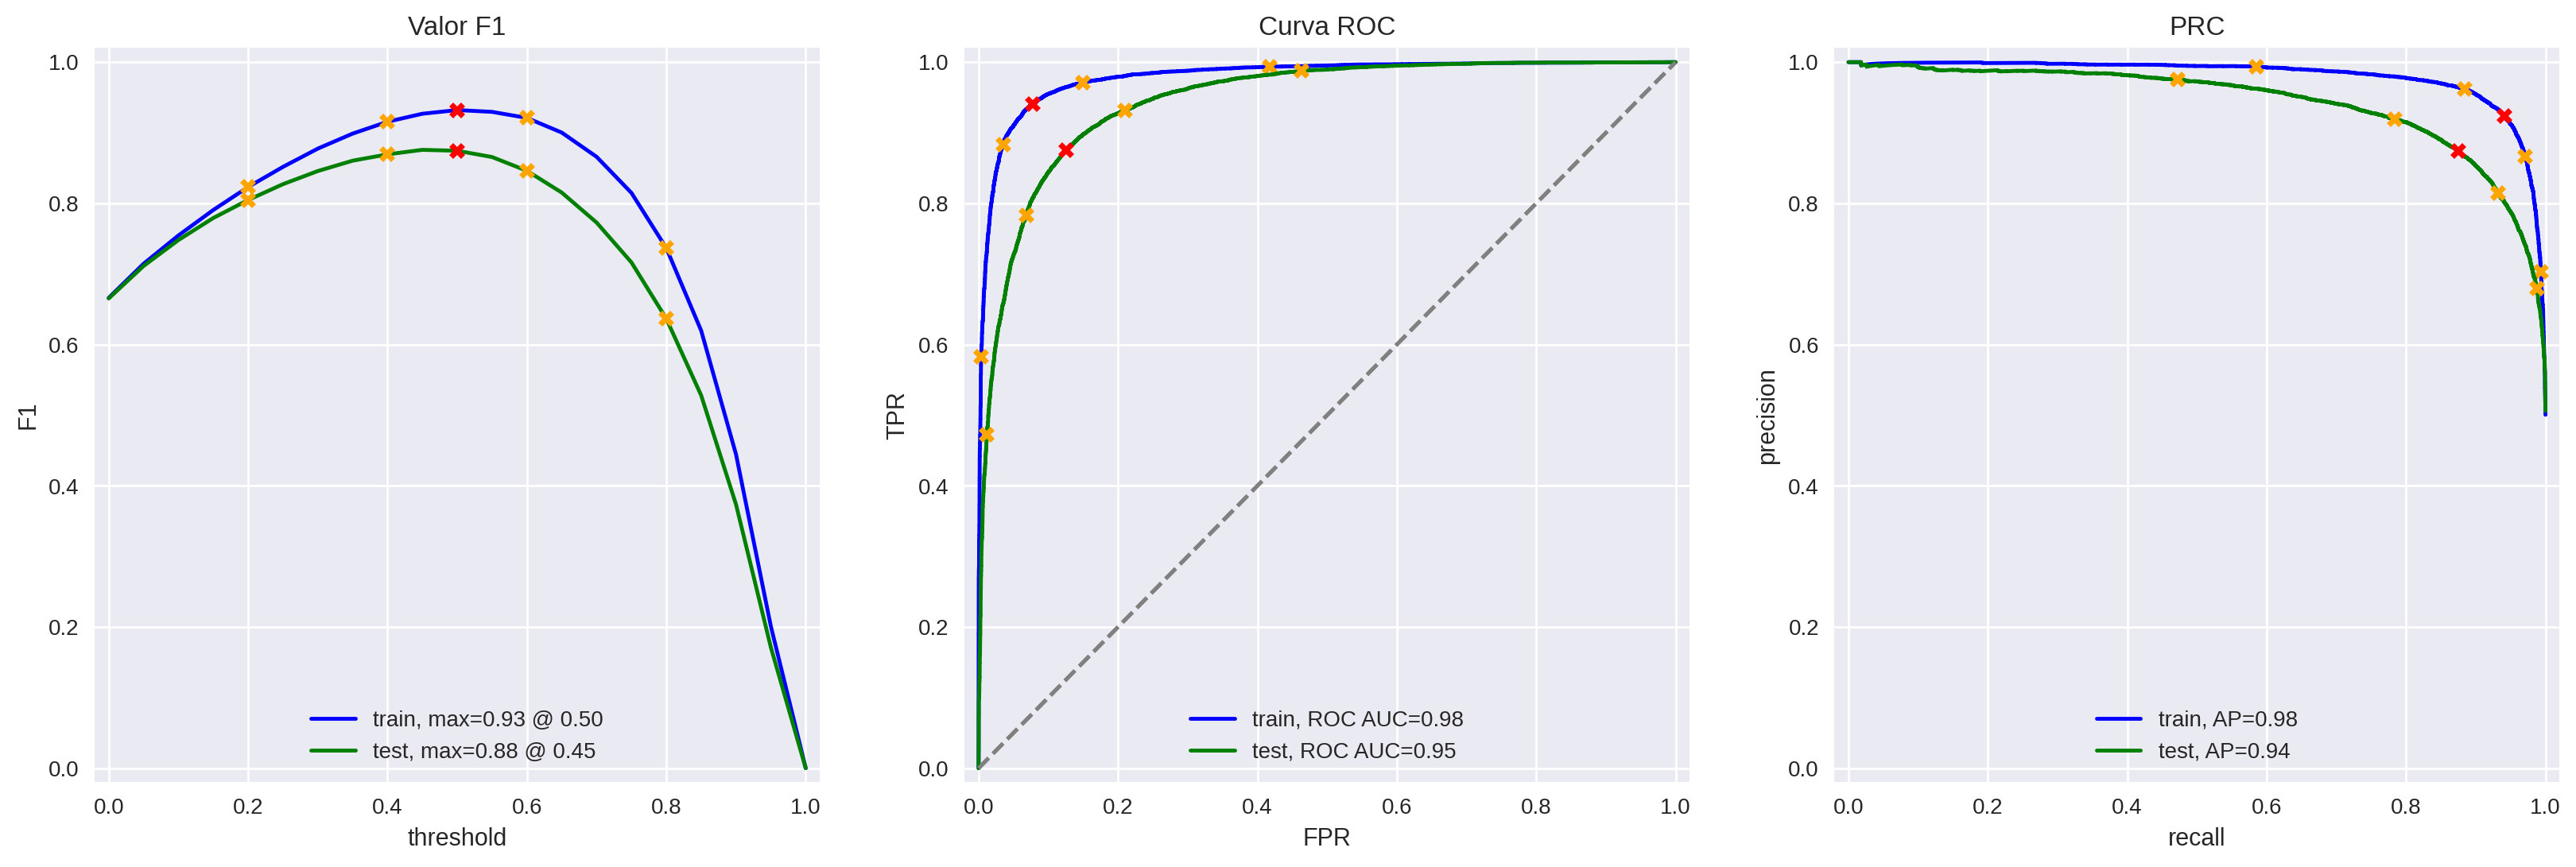

In [51]:
evaluate_model(model3, train_features3, train_target, test_features3, test_target)

### Model 4 - SpaCy, TF-IDF e LGBMClassifier

In [52]:
from lightgbm import LGBMClassifier

In [53]:
%%time 

model4 = LGBMClassifier(learning_rate=.1)
model4.fit(train_features3,train_target)

CPU times: user 49 s, sys: 269 ms, total: 49.3 s
Wall time: 49.3 s


LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


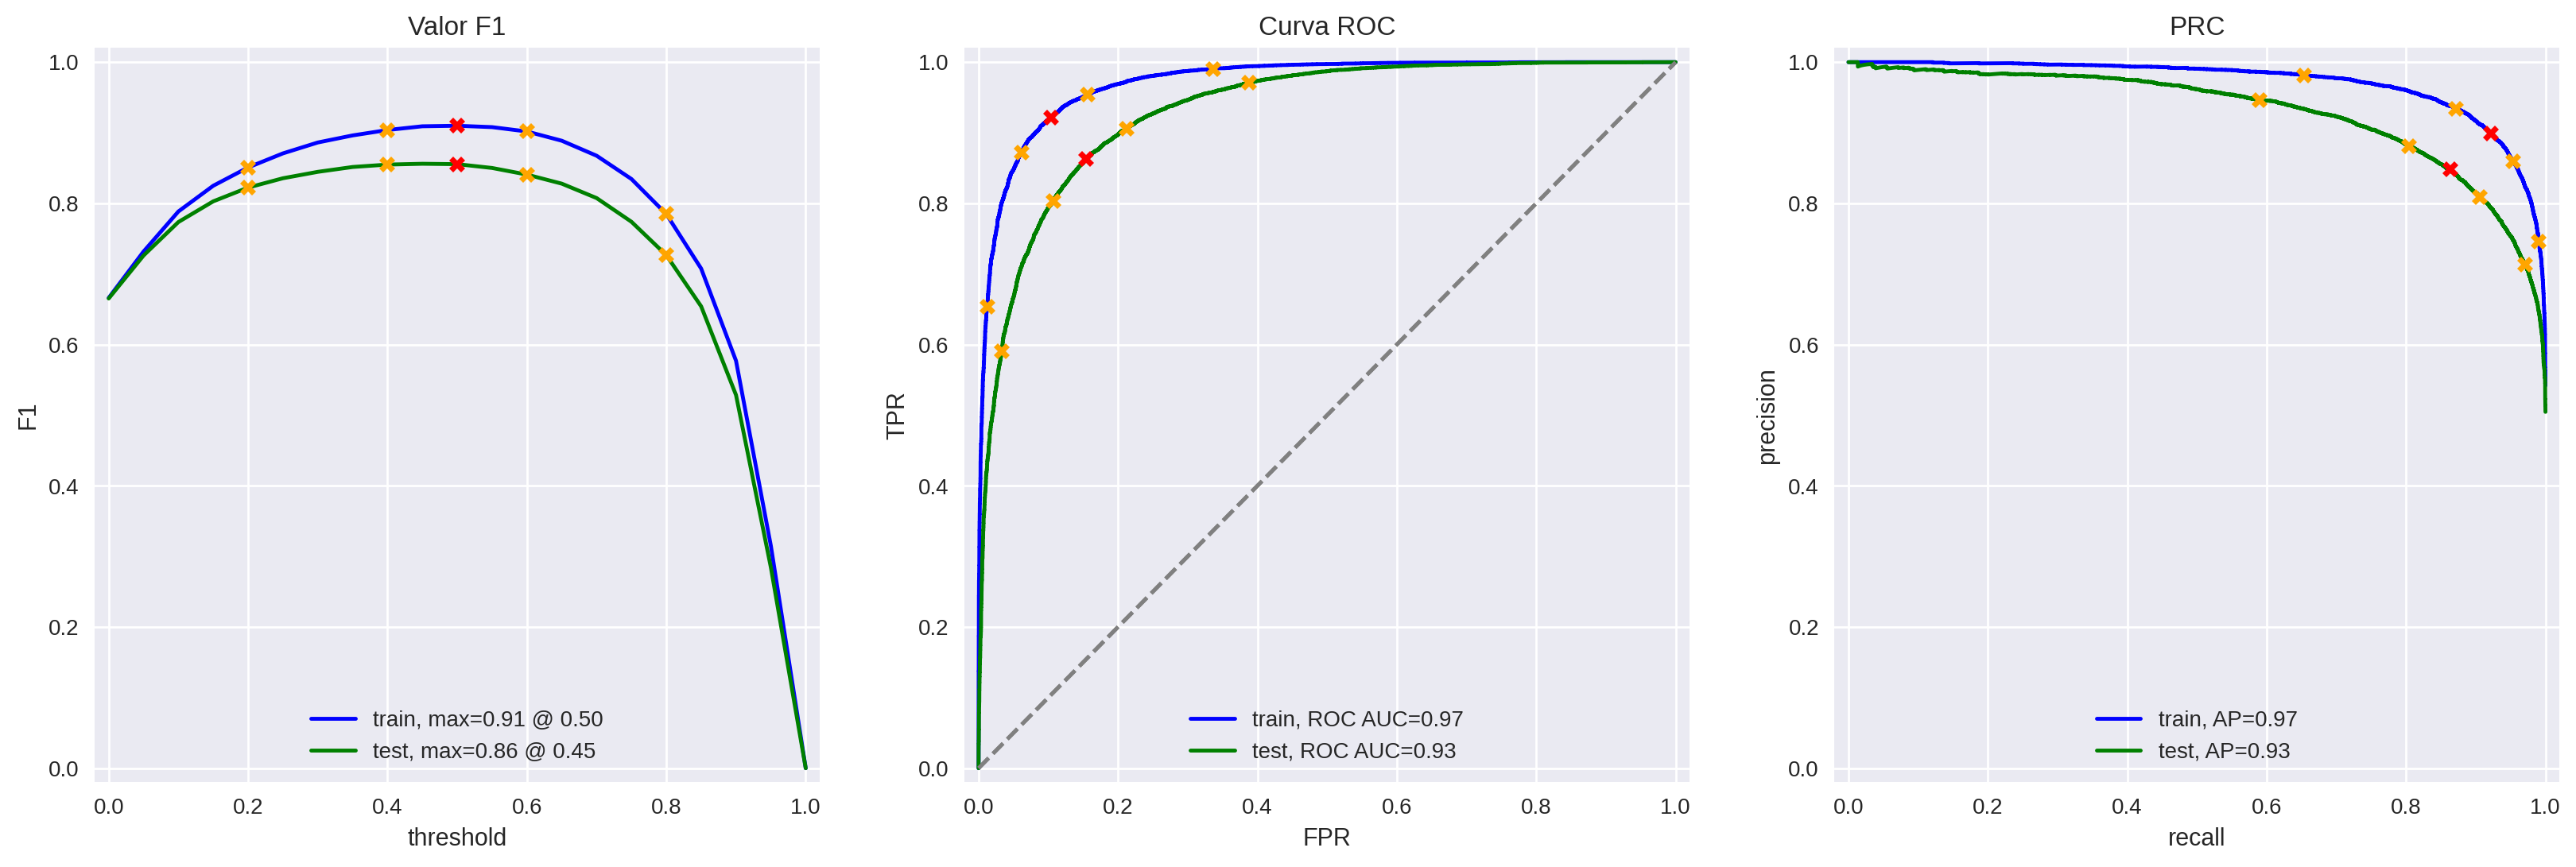

In [54]:
evaluate_model(model4, train_features3, train_target, test_features3, test_target)

###  Model 9 - BERT

This section was executed on google colab for better performance and computational time, link below
https://colab.research.google.com/drive/1Q6RiWsp-Dk99QVlQ8RZe-qQRBeCfTAPH?usp=sharing

In [55]:
import torch
import transformers

In [56]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção
    
    # <coloque seu código aqui para criar ids_list e attention_mask_list>
    for input_text in tqdm(texts,disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')
    
    # recebendo incorporações em lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        # <coloque seu código aqui para criar attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)].to(device))
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Atenção! A execução do BERT para milhares de textos pode levar muito tempo na CPU, pelo menos várias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas se 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# e carregar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My reviews

In [57]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews["review"].str.lower().str.replace("[^a-zA-Z]"," ")

my_reviews

,review,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...",eu simplesmente n o gostei n o meu tipo de ...
1,"Bem, eu fiquei entediado e dormi no meio do fi...",bem eu fiquei entediado e dormi no meio do fi...
2,Eu fiquei realmente fascinado com o filme,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,eu n o esperava que a nova vers o fosse t o bo...
5,"O filme tem seus prós e contras, mas eu sinto ...",o filme tem seus pr s e contras mas eu sinto ...
6,Que tentativa podre de comédia. Nem uma única ...,que tentativa podre de com dia nem uma nica ...
7,Lançar na Netflix foi uma jogada corajosa e eu...,lan ar na netflix foi uma jogada corajosa e eu...


### Model 3

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  eu simplesmente n o gostei  n o   meu tipo de filme 
0.48:  bem  eu fiquei entediado e dormi no meio do filme 
0.58:  eu fiquei realmente fascinado com o filme
0.51:  os atores pareciam muito velhos e desinteressados  e mesmo assim foram pagos para participar do film
0.44:  eu n o esperava que a nova vers o fosse t o boa  os escritores realmente se importaram com o materia
0.48:  o filme tem seus pr s e contras  mas eu sinto que em geral   um filme decente  eu posso me imaginar 
0.62:  que tentativa podre de com dia  nem uma  nica piada cai  todo mundo age de forma irritante e barulhe
0.52:  lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s


### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

**Conclusion**: The best-performing models were Model 1 (using NLTK, TF-IDF, and Logistic Regression), which achieved an F1 score of **0.88** on the test set, and Model 9 (using BERT) with an F1 score of **0.88**.

**Preprocessing Steps**:
1. Remove missing values.
2. Normalize the data (convert to lowercase, remove special characters).

**Model Performance on Test Set**:
- **Model 0**: Constant classifier - F1 score = **0.67**
- **Model 1**: NLTK, TF-IDF, and Logistic Regression - F1 score = **0.88**
- **Model 3**: SpaCy, TF-IDF, and Logistic Regression - F1 score = **0.87**
- **Model 4**: SpaCy, TF-IDF, and LightGBM - F1 score = **0.86**
- **Model 9**: BERT - F1 score = **0.88**
